In [27]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import pywt
import pywt.data
from helpers import mle_gamma

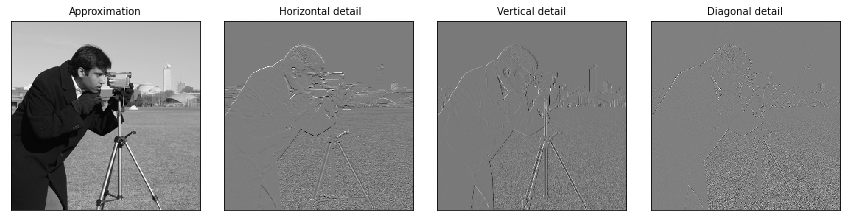

In [5]:
# Load image
original = pywt.data.camera()

# Wavelet transform of image, and plot approximation and details
titles = ['Approximation', ' Horizontal detail',
          'Vertical detail', 'Diagonal detail']
coeffs2 = pywt.dwt2(original, 'bior1.3')
LL, (LH, HL, HH) = coeffs2
fig = plt.figure(figsize=(12, 3))
for i, a in enumerate([LL, LH, HL, HH]):
    ax = fig.add_subplot(1, 4, i + 1)
    ax.imshow(a, interpolation="nearest", cmap=plt.cm.gray)
    ax.set_title(titles[i], fontsize=10)
    ax.set_xticks([])
    ax.set_yticks([])

fig.tight_layout()
plt.show()

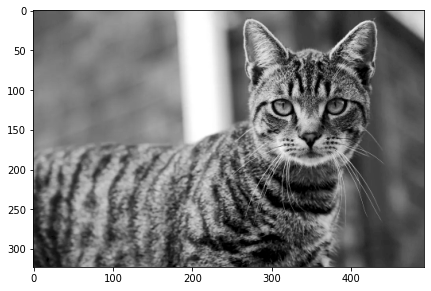

7.175900833082405 7.862817424470541 3.552569507176554


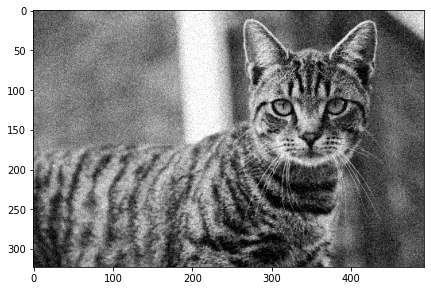

In [304]:
original = cv2.imread("cat.png", cv2.IMREAD_GRAYSCALE )
original = cv2.resize(original, (0, 0), fx = 0.5, fy = 0.5)
figure = plt.figure(figsize=(7,5))
plt.imshow(original, cmap=plt.cm.gray)
plt.show()

# before adding noise
coeffs2 = pywt.dwt2(original, 'haar')
LL_true, (LH_true, HL_true, HH_true) = coeffs2

gamma_LH = mle_gamma(LH_true.ravel())
gamma_HL = mle_gamma(HL_true.ravel())
gamma_HH = mle_gamma(HH_true.ravel())

print(gamma_LH, gamma_HL, gamma_HH)

# add noise
s = original.shape
sigma = 20
X = original + np.random.normal(scale=sigma, size=s)
X = np.clip(X, 0, 255)

figure = plt.figure(figsize=(7,5))
plt.imshow(X, cmap=plt.cm.gray)
plt.show()

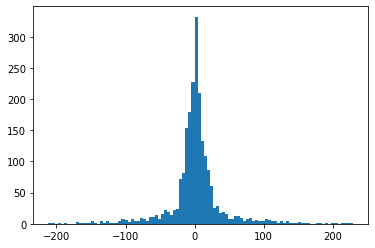

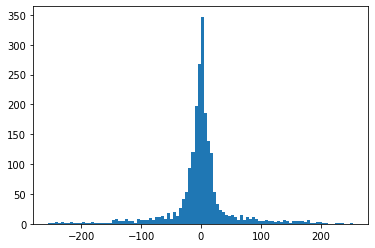

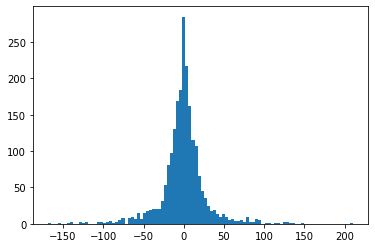

In [305]:
plt.hist(LH.ravel(), bins=100)
plt.show()
plt.hist(HL.ravel(), bins=100)
plt.show()
plt.hist(HH.ravel(), bins=100)
plt.show()

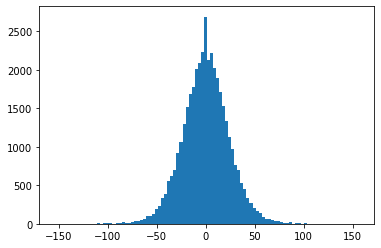

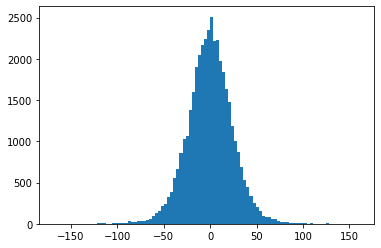

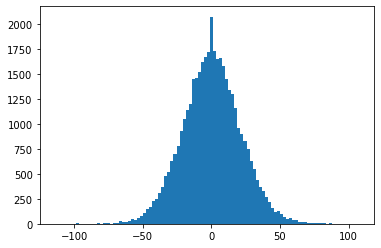

In [306]:
coeffs2 = pywt.dwt2(X, 'haar')
LL, (LH, HL, HH) = coeffs2

plt.hist(LH.ravel(), bins=100)
plt.show()
plt.hist(HL.ravel(), bins=100)
plt.show()
plt.hist(HH.ravel(), bins=100)
plt.show()

In [307]:
LH_map = map_estimate(LH, sigma=sigma, gamma=gamma_LH)
LH_mmse = mmse_estimate(LH, sigma=sigma, gamma=gamma_LH)
print("MSE LH ML-MAP-MMSE", np.mean(np.square(LH-LH_true)), np.mean(np.square(LH_map-LH_true)), np.mean(np.square(LH_mmse-LH_true)))

HL_map = map_estimate(HL, sigma=sigma, gamma=gamma_HL)
HL_mmse = mmse_estimate(HL, sigma=sigma, gamma=gamma_HL)
print("MSE HL ML-MAP-MMSE", np.mean(np.square(HL-LH_true)), np.mean(np.square(HL_map-LH_true)), np.mean(np.square(HL_mmse-LH_true)))

HH_map = map_estimate(HH, sigma=sigma, gamma=gamma_HH)
HH_mmse = mmse_estimate(HH, sigma=sigma, gamma=gamma_HH)
print("MSE HH ML-MAP-MMSE", np.mean(np.square(HH-LH_true)), np.mean(np.square(HH_map-LH_true)), np.mean(np.square(HH_mmse-LH_true)))

MSE LH ML-MAP-MMSE 380.47836439614423 157.7404068594467 122.58631676988281
MSE HL ML-MAP-MMSE 768.2684089884498 201.66755475798846 227.12173085499302
MSE HH ML-MAP-MMSE 626.1079906434761 183.70602184872374 185.1653237089735


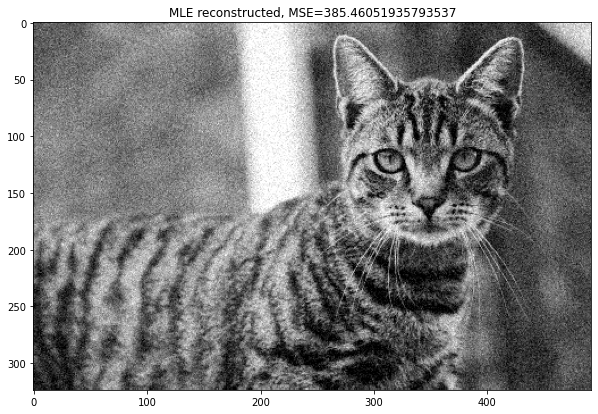

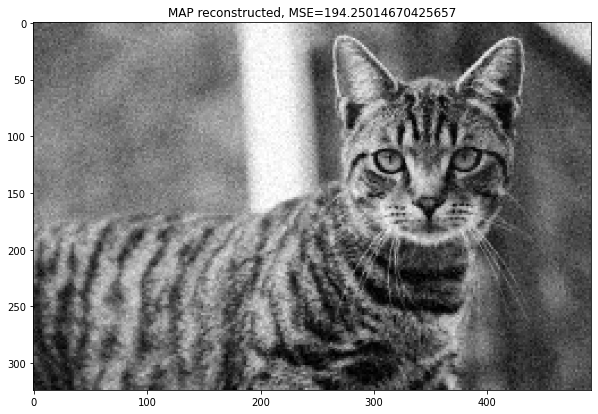

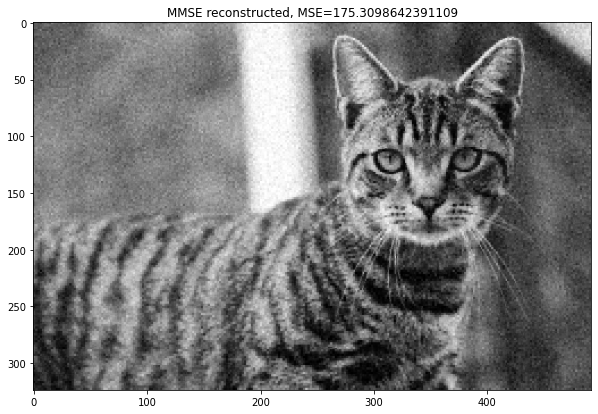

In [308]:
inv_mle = pywt.idwt2((LL, (LH, HL, HH)), 'haar')
figure = plt.figure(figsize=(10,7))
plt.imshow(inv_mle, cmap=plt.cm.gray)
plt.title(f"MLE reconstructed, MSE={np.mean(np.square(inv_mle[:323,:]-original))}")
plt.show()

inv_map = pywt.idwt2((LL, (LH_map, HL_map, HH_map)), 'haar')
figure = plt.figure(figsize=(10,7))
plt.imshow(inv_map, cmap=plt.cm.gray)
plt.title(f"MAP reconstructed, MSE={np.mean(np.square(inv_map[:323,:]-original))}")
plt.show()

inv_mmse = pywt.idwt2((LL, (LH_mmse, HL_mmse, HH_mmse)), 'haar')
figure = plt.figure(figsize=(10,7))
plt.imshow(inv_mmse, cmap=plt.cm.gray)
plt.title(f"MMSE reconstructed, MSE={np.mean(np.square(inv_mmse[:323,:]-original))}")
plt.show()

In [309]:
from hyperparameters_estimations import gradient_descent_line_search, ml_objective_gamma_sigma
from helpers import map_estimate, mmse_estimate, mse
import tqdm

In [310]:
x = LH.ravel()
N_MML_estimates = 5
obj_min = np.inf

for j in tqdm.tqdm(range(N_MML_estimates)):
    # print(gamma, i, j)
    gamma_est_, sigma_est_ = -1, -1
    while gamma_est_ is None or gamma_est_ == np.nan or gamma_est_ < 0 or sigma_est_ is None or sigma_est_ == np.nan or sigma_est_ < 0:
        # estimate hyper parameters
        gamma_init = np.random.randint(1, 20)
        sigma_init = np.random.randint(1, 20)
        gamma_est_, _ = gradient_descent_line_search(gamma_init, sigma_init, x, steps=50, default_alpha=0.001)
    obj = ml_objective_gamma_sigma([gamma_est_, gamma_est_], x)
    if obj < obj_min:
        obj_min = obj
        gamma_est, sigma_est = gamma_est_, gamma_est_
gamma_est_LH, sigma_est_LH = gamma_est, sigma_est

  0%|                                                                                                                    | 0/5 [45:19<?, ?it/s]


KeyboardInterrupt: 

In [ ]:
print(gamma_est_LH, sigma_est_LH)

In [187]:
LH_map = map_estimate(LH, sigma=sigma_est, gamma=7.2)
LH_mmse = mmse_estimate(LH, sigma=sigma_est, gamma=7.2)

In [188]:
np.mean(np.square(LH/255-LH_true/255))

0.012187993289651389

In [189]:
np.mean(np.square(LH_map/255-LH_true/255))

0.009637721004861039

In [190]:
np.mean(np.square(LH_mmse/255-LH_true/255))

0.0095766362932709

In [55]:
cD_map = map_estimate(cD, sigma, gamma=gamma_est)
cD_mmse = mmse_estimate(cD, sigma, gamma=gamma_est)

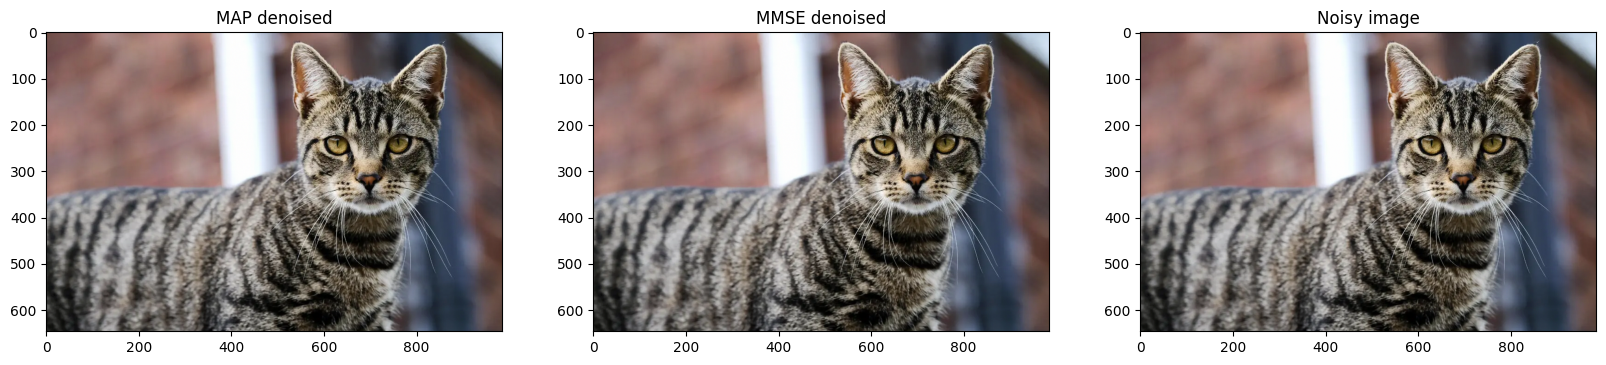

In [56]:
Xinv_map = pywt.idwt(cA, cD_map, 'db2')
imageInv_map = Xinv_map.astype(np.uint8).reshape(s)[:,:,::-1]
Xinv_mmse = pywt.idwt(cA, cD_mmse, 'db2')
imageInv_mmse = Xinv_mmse.astype(np.uint8).reshape(s)[:,:,::-1]

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(20,15))
axes = axes.ravel()
axes[0].imshow(imageInv_map)
axes[0].set_title("MAP denoised")
axes[1].imshow(imageInv_mmse)
axes[1].set_title("MMSE denoised")
axes[2].imshow(X_show)
axes[2].set_title("Noisy image")
plt.show()

In [57]:
original_show = original[:,:,::-1]

In [58]:
print("MAP MSE", mse(original_show, imageInv_map))
print("MMSE MSE", mse(original_show, imageInv_mmse))
print("Noise MSE", mse(original_show, X_show))

MAP MSE 1.3313274976033693
MMSE MSE 1.3317811548878167
Noise MSE 1.323068944382455
